<a href="https://colab.research.google.com/github/AnnaPikuleva/Test_tacsk_buffer/blob/main/test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузить 2 набора точечных данных OSM, например, здания и poi на адекватную по размеру территорию. Построить буферную зону радиусом 500 м вокруг одного набора и, создав новое поле в этом первом наборе, записать в него, сколько точек из второго набора попадает в буфер.


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [ ]:
pip install pyrosm

In [ ]:
pip install matplotlib==3.1.3 

In [ ]:
pip install geopandas

In [ ]:
pip install osmnx

In [ ]:
import geopandas as gpd
import pandas
import numpy as np
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon

Район для выборки - Васильевский остров

In [ ]:
place = 'Василеостровский район,Санкт-Петербург,Россия'

In [ ]:
UTM_zone = 32636

Скачиваемся супермаркеты

In [ ]:
tags = {"shop": "supermarket"}
supermarket = ox.geometries_from_place(place, tags)
supermarket = supermarket.to_crs(32636)
supermarket.reset_index(inplace=True)
supermarket = supermarket[['osmid','geometry','alt_name:ru']]
supermarket['geometry'] = supermarket['geometry'].centroid.buffer(500)
supermarket[['osmid','geometry']]
type(supermarket)

geopandas.geodataframe.GeoDataFrame

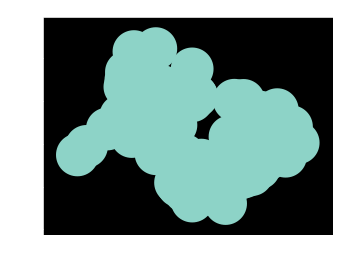

In [ ]:
supermarket.plot()

Скачиваем жилые дома

In [ ]:
tags = {"building": "apartments"}
apartments = ox.geometries_from_place(place, tags)
apartments = apartments.to_crs(UTM_zone)
apartments.reset_index(inplace=True)
apartments['geometry'] = apartments['geometry'].centroid
apartments.rename(columns = {'osmid' : 'id'}, inplace = True) 
apartments = apartments[['id','geometry']]
type(apartments)

/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


geopandas.geodataframe.GeoDataFrame

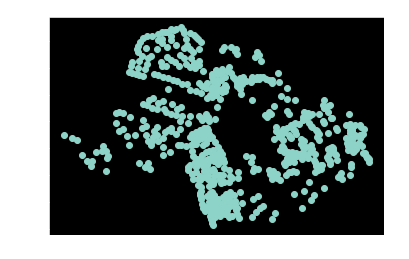

In [ ]:
apartments.plot()

Соединяем данные

In [ ]:
itog = gpd.sjoin(apartments, supermarket[['osmid','geometry']], how='left', op='intersects')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


In [ ]:
itog

,id,geometry,index_right,osmid
0,16092801,POINT (345498.605 6649059.978),33.0,3.929674e+09
0,16092801,POINT (345498.605 6649059.978),42.0,5.148471e+09
0,16092801,POINT (345498.605 6649059.978),57.0,7.961225e+09
0,16092801,POINT (345498.605 6649059.978),3.0,8.251529e+08
0,16092801,POINT (345498.605 6649059.978),56.0,7.468697e+09
...,...,...,...,...
621,12854908,POINT (343545.161 6647669.106),48.0,6.451273e+09
622,12854912,POINT (343468.592 6647762.724),65.0,8.909143e+09
622,12854912,POINT (343468.592 6647762.724),48.0,6.451273e+09
623,12858141,POINT (343635.646 6647921.579),65.0,8.909143e+09


osmid - id супермаркетов, поэтому группируем по этому полю 

In [ ]:
df = itog.groupby(['osmid']).count()

In [ ]:
df['id']

osmid
1.696013e+07    38
3.079552e+07    21
6.526994e+08    18
7.773492e+08    65
7.915530e+08    82
                ..
8.825748e+09    59
8.898735e+09    55
8.909143e+09    12
8.911484e+09    44
9.310464e+09    28
Name: id, Length: 76, dtype: int64

In [ ]:
supermarket = supermarket.merge(df['id'],on='osmid',how='left')

In [ ]:
supermarket.rename(columns = {'id' : 'number_of_house'}, inplace = True) 

In [ ]:
supermarket

,osmid,geometry,alt_name:ru,number_of_house
0,652699378,"POLYGON ((348020.086 6647280.496, 348017.678 6...",Пятерочка,18
1,791553037,"POLYGON ((346238.405 6647092.763, 346235.998 6...",NaN,82
2,825152797,"POLYGON ((345054.800 6649330.330, 345052.393 6...",Пятерочка,25
3,825152923,"POLYGON ((345759.838 6648992.649, 345757.431 6...",Пятерочка,28
4,841443848,"POLYGON ((346020.021 6648326.025, 346017.613 6...",NaN,56
...,...,...,...,...
71,823865756,"POLYGON ((348575.991 6647740.666, 348573.583 6...",NaN,48
72,977040751,"POLYGON ((348106.625 6648116.305, 348104.218 6...",Пятерочка,78
73,1031310102,"POLYGON ((348807.689 6647710.854, 348805.281 6...",NaN,52
74,1052464573,"POLYGON ((348773.936 6648389.516, 348771.529 6...",NaN,52
